# 变分参数篇  
经过二次量子化、编码后的哈密顿量本质就是一个矩阵，接下来的任务就是找到这个矩阵的最小本征值对应的本征态.  
本征态对应着量子态，也对应着波函数。获得这个本征态的方式叫做变分法，本质是尽量接近和模仿这个未知的波函数。  
那么，在qiskit中变分参数是如何训练的呢？有哪些必须掌握的API呢？  
<font color=red>【关键词】:变分线路Ansatz、变分参数、优化过程、优化器</font>  
如果你认为自己理解了,练习自行完成

In [1]:
from qiskit.circuit import QuantumCircuit,Parameter
from qiskit.quantum_info import SparsePauliOp,Pauli
from qiskit.visualization import array_to_latex
import numpy as np

#先构造一个我们自己编的哈密顿量
hamiltonian = SparsePauliOp(data=['XZZ','ZXI','IXZ','XZX','III'],coeffs=[0.7,0.8,0.9,0.2,0.65])
#展示一下哈密顿量矩阵长啥样
array_to_latex(hamiltonian.to_matrix()) 

<IPython.core.display.Latex object>

In [2]:
E,U = np.linalg.eig(hamiltonian.to_matrix())
print(f'哈密顿量对应的最小本征值是{E.min()}\n最小本征值对应的本征态是{U[np.argmin(E)]}')
#想一下为啥本征态的维度是这样？

哈密顿量对应的最小本征值是(-1.4538404810405308+0j)
最小本征值对应的本征态是[ 0.48006009-0.j  0.46193977+0.j  0.48006009-0.j -0.46193977-0.j
 -0.13979383+0.j  0.19134172+0.j  0.13979383+0.j -0.19134172+0.j]


以上使用numpy(经典计算的方法)解得的答案，下面使用量子变分线路

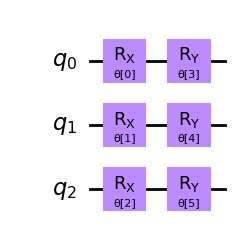

本线路里包含6个变分参数!


In [3]:
from qiskit.circuit.library import TwoLocal
qc = QuantumCircuit(3)
qc.append(TwoLocal(num_qubits=3,rotation_blocks=['rx','ry'],reps=0),range(3))
display(qc.decompose(reps=2).draw('mpl'))
print(f'本线路里包含{qc.num_parameters}个变分参数!')

我们构造出了一个变分线路 希望通过这个线路来生成对应本征态的量子态 但是根据线路里包含了需要给出的变分参数  
接下来我们需要找到最优的变分参数 才能够更好地逼近未知的最小本征值对应的本征态  
#### 重点1：优化器  
优化器虽然qiskit官方也有 但是如果去看源码 本质都是使用了scipy.optimize的优化方法  
因此 我们直接使用qiskit优化器他爹 scipy.optimize  
##### 1.1 目标函数咋设置？  
目标函数返回的值应当就是我们想要最大/最小化的函数值，比如在这里 就是我们的最小化能量E=$\bra{\psi} H\ket{\psi}$


In [4]:
from qiskit.primitives import Estimator
def object_value(x):
    print(f'能量期望值测量函数接受到的参数是{x}')
    estimator = Estimator()
    job = estimator.run(circuits=qc,observables=hamiltonian,parameter_values=x)
    print(f'能量期望值是{job.result().values[0]}')
    means_energy = job.result().values[0]
    return means_energy

#这个函数根据给定的参数列表 会把参数填进量子线路中 然后测量能量期望值，这部分不熟悉的同学去看Estimator
#https://qiskit.org/documentation/stubs/qiskit.primitives.Estimator.html#estimator

##### 1.2 梯度和回调函数的设定  
在优化器优化算法中,往往需要函数的梯度值作为依据来更新参数，这和机器学习中的梯度下降法同理，是一种普遍的优化策略。  
然而，在此处并不需要设置梯度，因为我们想要近似的波函数是未知的,因此无法直接写出梯度表达式来。  
所以 优化器对自动使用近似求解梯度的算法，比如给参数加一个很小的扰动，根据导数的定义式求出单个参数的导数，导数向量就是梯度  
总之 此处不设置梯度的计算函数，而是默认使用优化器自带的梯度求解方法  

回调函数可以让我们知道 优化器咋算出最后它认为最优的参数的，因此学习优化器时，应当设置一波 看看这玩意儿背着咱干了啥  

给参数设定范围也很重要，不然给个参数设个几百万不很离谱吗 在这里咱们设置[-2pi,2pi] 想想为什么？

In [5]:
def mycall_back(*args):
    print(f'回调函数收到了{args}')

In [6]:
from scipy.optimize import minimize
#fun 目标函数
#x0 参数的初始值
#method 不同method选用不同算法 默认得了
#bound 给变分参数加个边界 不然一个参数给你定了几百万 合适吗？ 
opt_result = minimize(fun=object_value,
                      x0=[0.2]*qc.num_parameters,
                      bounds=[[-2*np.pi,2*np.pi]]*qc.num_parameters,
                      callback=mycall_back)
print(f'----------------------优化结果展示------------------------------')
print(f'最优参数最终是={opt_result.x}\n优化后的最小能量是={opt_result.fun}')

能量期望值测量函数接受到的参数是[0.2 0.2 0.2 0.2 0.2 0.2]
能量期望值是1.1009736703267745
能量期望值测量函数接受到的参数是[0.20000001 0.2        0.2        0.2        0.2        0.2       ]
能量期望值是1.100973669715899
能量期望值测量函数接受到的参数是[0.2        0.20000001 0.2        0.2        0.2        0.2       ]
能量期望值是1.1009736694126058
能量期望值测量函数接受到的参数是[0.2        0.2        0.20000001 0.2        0.2        0.2       ]
能量期望值是1.1009736697538108
能量期望值测量函数接受到的参数是[0.2        0.2        0.2        0.20000001 0.2        0.2       ]
能量期望值是1.1009736700899473
能量期望值测量函数接受到的参数是[0.2        0.2        0.2        0.2        0.20000001 0.2       ]
能量期望值是1.1009736857416241
能量期望值测量函数接受到的参数是[0.2        0.2        0.2        0.2        0.2        0.20000001]
能量期望值是1.1009736765861908
能量期望值测量函数接受到的参数是[ 0.26108756  0.29141687  0.25729637  0.22368272 -1.34148496 -0.42594163]
能量期望值是-0.8590980831000532
能量期望值测量函数接受到的参数是[ 0.26108757  0.29141687  0.25729637  0.22368272 -1.34148496 -0.42594163]
能量期望值是-0.8590980808238124
能量期望值测量函数接受到的参数是[ 0.26108756  0.29141688  0.2572

分析结果可以看到 离真正的最小值-1.4还有一定差距 这是由于ansatz过于简单导致的 此处不提  
#### Final: 得到的变分参数如何加回线路里  
  现在得到了最优参数 但是如何加进线路里，得到一个不带任何未知数的量子线路呢？这部分不难 纯粹教下api

没有绑定参数的线路是...


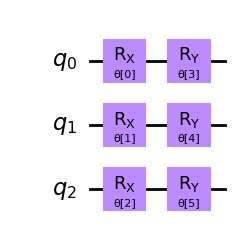

绑定参数后的线路是...


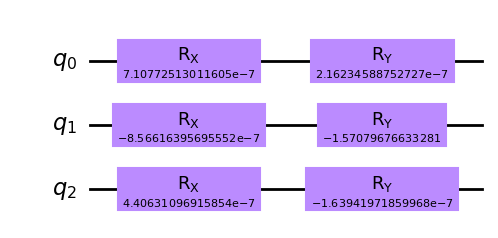

In [7]:
print(f'没有绑定参数的线路是...')
display(qc.decompose(reps=2).draw('mpl'))
print(f'绑定参数后的线路是...')
qc = qc.bind_parameters(opt_result.x)
display(qc.decompose(reps=2).draw('mpl'))

### 课后练习  
背景: 注意看，看完教程的这个男人叫小帅。就在前不久，他的女友小美被大魔王抓走了，大魔王说如果找不到下面Ansatz的最优参数，就把小美杀掉。  
此时小帅刚学完变分参数的优化 小帅立刻马不停蹄地试了起来...

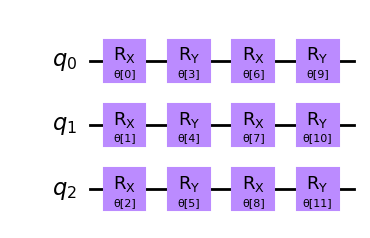

In [10]:
#先构造一个我们自己编的哈密顿量
new_hamiltonian = SparsePauliOp(data=['XZZ','ZXI','IXZ','XZX','III','ZXZ'],coeffs=[0.7,0.8,0.9,0.2,0.65,0.78])
qc = QuantumCircuit(3)
qc.append(TwoLocal(num_qubits=3,rotation_blocks=['rx','ry'],reps=1),range(3))
display(qc.decompose(reps=2).draw('mpl'))